# Centre for Marine Applied Research (CMAR) Water Quality dataset

:::{note}
This notebook documents how to download the data from the ERDDAP on CIOOS Atlantic and produce a file called `dataset.csv` that is used in subsequent steps in the analysis.

This dataset file is already included in the git repository so this notebook does not need to be run again.
:::

# Download the Dataset

We want to analyze the Centre for Marine Applied Research ([CMAR](https://cmar.ca/coastal-monitoring-program/#data)) Water Quality dataset. This dataset is comprised of various moorings with temperator sensors at fixed depths at many locations around Nova Scotia.

<img src="https://cmar.ca/wp-content/themes/cmar/images/logo-cmar.png" width="30%">

<img src="https://cmar.ca/wp-content/uploads/sites/22/2023/12/Detailed-Version-Flipped-2-768x994.png" width="30%"/>

In [32]:
from erddapy import ERDDAP
import os
import pandas as pd
#import csv
#import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

The data is available from [CIOOS Atlantic](https://catalogue.cioosatlantic.ca/en/organization/cmar)

In [2]:
e = ERDDAP(
    server = "https://cioosatlantic.ca/erddap",
    protocol = "tabledap"
)

Determine the `datasetID` for each CMAR Water Quality dataset.

The study period is 2020-09-01 to 2024-08-31.

In [3]:
e.dataset_id = 'allDatasets'
e.variables = ['datasetID', 'institution', 'title', 'minTime', 'maxTime']

# only grab data from county with data within study period
e.constraints = {'maxTime>=': '2020-09-01', 'minTime<=': '2024-08-31'}
df_allDatasets = e.to_pandas()

In [4]:
df_CMAR_datasets = df_allDatasets[df_allDatasets['institution'].str.contains('CMAR') & df_allDatasets['title'].str.contains('Water Quality Data')].copy()
df_CMAR_datasets['county'] = df_CMAR_datasets['title'].str.removesuffix(' County Water Quality Data')

df_CMAR_datasets.sample(5)

,datasetID,institution,title,minTime (UTC),maxTime (UTC),county
55,v6sa-tiit,Centre for Marine Applied Research (CMAR),Richmond County Water Quality Data,2015-11-26T21:00:00Z,2024-10-17T17:49:38Z,Richmond
10,gfri-gzxa,Centre for Marine Applied Research (CMAR),Colchester County Water Quality Data,2020-10-01T14:00:00Z,2023-06-07T13:16:25Z,Colchester
24,a9za-3t63,Centre for Marine Applied Research (CMAR),Inverness County Water Quality Data,2015-11-26T21:20:51Z,2022-10-24T12:45:00Z,Inverness
57,mq2k-54s4,CMAR,Shelburne County Water Quality Data,2018-02-13T16:32:00Z,2024-07-25T12:15:00Z,Shelburne
2,knwz-4bap,Centre for Marine Applied Research (CMAR),Annapolis County Water Quality Data,2020-06-11T19:15:00Z,2023-05-24T17:23:45Z,Annapolis


For each of these datasets, we download the temperature data locally.

In [5]:
e.variables = [
 'waterbody',
 'station',
 'deployment_start_date',
 'deployment_end_date',
 'time',
 'depth',
 'temperature',
 'qc_flag_temperature']

e.constraints = { "time>=": "2020-09-01", "time<=": "2024-08-31" }

This next step can takes 15+ minutes so we locally cache the data so it only has to be downloaded once.

In [6]:
%%time

os.makedirs('data', exist_ok=True)

for index, row in df_CMAR_datasets.iterrows():

    csvfile = f"data/{row['county']}.csv.gz"

    if os.path.exists(csvfile):
        continue

    print(f"Downloading {row['title']}...")
    e.dataset_id = row['datasetID']
    df = e.to_pandas()

    df.to_csv(csvfile, compression='gzip', index=False)

CPU times: user 1min 32s, sys: 3.04 s, total: 1min 35s
Wall time: 21min 24s


We now have the following `.csv` files stored locally:

In [6]:
!ls -lh data/

total 107M
-rw-r--r-- 1 jmunroe jmunroe 1.4M Aug 15 09:07 Annapolis.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 4.9M Aug 15 09:08 Antigonish.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 1.3M Aug 15 09:08 Colchester.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 5.7M Aug 15 09:09 Digby.csv.gz
-rw-r--r-- 1 jmunroe jmunroe  45M Aug 15 09:16 Guysborough.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 7.9M Aug 15 09:18 Halifax.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 1.5M Aug 15 09:18 Inverness.csv.gz
-rw-r--r-- 1 jmunroe jmunroe  17M Aug 15 09:21 Lunenburg.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 2.0M Aug 15 09:22 Pictou.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 2.9M Aug 15 09:23 Queens.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 3.5M Aug 15 09:24 Richmond.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 6.4M Aug 15 09:25 Shelburne.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 8.1K Aug 15 09:25 Victoria.csv.gz
-rw-r--r-- 1 jmunroe jmunroe 8.3M Aug 15 09:28 Yarmouth.csv.gz


## Organize observations by physical location

We need to organize and sort the observations so that we are considering only the observation for a single sensor in temporal order.

This will remove all of the duplicated metadata within each `.csv` files.

In [12]:
os.makedirs('segments', exist_ok=True)

all_segment_metadata = []
for index, row in tqdm(list(df_CMAR_datasets.iterrows())):

    csvfile = f"data/{row['county']}.csv.gz"

    df = pd.read_csv(csvfile)
    
    df['segment'] = df[['waterbody', 'station', 'depth (m)',
                     'deployment_start_date (UTC)', 'deployment_end_date (UTC)',
                     ]].agg(lambda x: row['county'] + '_' + '_'.join([str(y) for y in x]), axis=1)

    df_metadata = df[['segment', 'waterbody', 'station', 'depth (m)',
                     'deployment_start_date (UTC)', 'deployment_end_date (UTC)',
                     ]]

    df_metadata = df_metadata.drop_duplicates()
    all_segment_metadata.append(df_metadata)
    
    df_data = df.drop(columns=['waterbody', 'station', 'depth (m)',
                                 'deployment_start_date (UTC)', 'deployment_end_date (UTC)',
                              ])
    
    df_data = df_data.sort_values(by=['segment', 'time (UTC)'])

    df_data.set_index(['segment', 'time (UTC)'], inplace=True)

    for key, segment_df in df_data.groupby(level=0):
        csvfile = f'segments/{key}.csv'
        segment_df = segment_df.droplevel(0)
        segment_df.to_csv(csvfile)

df_metadata = pd.concat(all_segment_metadata)
df_metadata.set_index('segment', inplace=True)
df_metadata.to_csv('metadata.csv')

100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [02:05<00:00,  8.94s/it]


In [13]:
!ls -lh segments/ | wc

   1082   12409  148063


We have 1082 distinct observational time series taken at various locations and depths around Nova Scotia during the period of 2020-09-01 to 2024-08-31

In [14]:
df_metadata.sample(8)

,waterbody,station,depth (m),deployment_start_date (UTC),deployment_end_date (UTC)
segment,,,,,
Halifax_Lawrencetown Beach_Lawrencetown Beach_2.0_2023-08-22T00:00:00Z_2024-09-12T00:00:00Z,Lawrencetown Beach,Lawrencetown Beach,2.0,2023-08-22T00:00:00Z,2024-09-12T00:00:00Z
Guysborough_Chedabucto Bay_Rook Island 1_2.0_2024-07-03T00:00:00Z_2024-10-17T00:00:00Z,Chedabucto Bay,Rook Island 1,2.0,2024-07-03T00:00:00Z,2024-10-17T00:00:00Z
Shelburne_Green Harbour_Blue Island_10.0_2022-08-11T00:00:00Z_2023-07-13T00:00:00Z,Green Harbour,Blue Island,10.0,2022-08-11T00:00:00Z,2023-07-13T00:00:00Z
Lunenburg_Mahone Bay_Upper Blandford_5.0_2022-05-13T00:00:00Z_2022-11-19T00:00:00Z,Mahone Bay,Upper Blandford,5.0,2022-05-13T00:00:00Z,2022-11-19T00:00:00Z
Lunenburg_Mahone Bay_Upper Blandford_27.0_2021-05-20T00:00:00Z_2024-05-30T00:00:00Z,Mahone Bay,Upper Blandford,27.0,2021-05-20T00:00:00Z,2024-05-30T00:00:00Z
Antigonish_Antigonish Harbour_1443_1.0_2024-07-04T00:00:00Z_2024-10-18T00:00:00Z,Antigonish Harbour,1443,1.0,2024-07-04T00:00:00Z,2024-10-18T00:00:00Z
Annapolis_Annapolis Basin_Lobster Ledge_4.0_2022-06-20T00:00:00Z_2023-05-24T00:00:00Z,Annapolis Basin,Lobster Ledge,4.0,2022-06-20T00:00:00Z,2023-05-24T00:00:00Z
Lunenburg_St. Margarets Bay_Birchy Head_5.0_2021-05-21T00:00:00Z_2021-11-26T00:00:00Z,St. Margarets Bay,Birchy Head,5.0,2021-05-21T00:00:00Z,2021-11-26T00:00:00Z


# Combine Time Series and Downsample

In [25]:
df_metadata = pd.read_csv('metadata.csv')

Sensors are deployed many different depths in the water column. 

In [26]:
df_metadata['depth (m)'].unique()

array([ 2.  ,  6.  ,  4.  ,  1.  ,  1.3 ,  0.5 ,  1.5 ,  0.4 ,  0.8 ,
        1.6 , 16.  , 15.  , 14.  ,  0.  ,  5.  ,  7.  , 30.  , 18.  ,
       10.  , 20.  ,  3.  ,  3.5 ,  0.41, 26.  , 25.  , 75.  , 40.  ,
       50.  , 22.  , 28.  , 36.  ,  9.  , 60.  , 44.  , 24.  , 27.  ,
       12.  , 21.  , 16.5 ,  8.  , 17.5 , 37.  , 11.  , 13.  ,  4.5 ])

Most often, there are standard depths that are most often used:

In [27]:
df_metadata['depth (m)'].value_counts().head(15)

depth (m)
2.0     195
5.0     184
10.0    156
15.0    132
20.0     93
1.0      50
30.0     35
25.0     25
0.5      18
40.0     16
4.0      14
3.0      13
1.5      10
8.0      10
27.0     10
Name: count, dtype: int64

Let's group these observation segments into more limited number of study sites where the waterbody, station, and depth are the same even if the sensor itself is replaced.

In [28]:
depths_list = [2.0, 5.0, 10.0, 15.0, 20.0]
study_sites = df_metadata[df_metadata['depth (m)'].isin(depths_list)][['waterbody', 'station', 'depth (m)']].drop_duplicates()
study_sites.reset_index(drop=True, inplace=True)

In [29]:
study_sites

,waterbody,station,depth (m)
0,Annapolis Basin,Cornwallis,2.0
1,Annapolis Basin,Lobster Ledge,2.0
2,Grahams Cove,Captains Pond,2.0
3,St. Georges Bay,St. Georges Bay S,15.0
4,Antigonish Harbour,1442,2.0
...,...,...,...
196,Careys Cove,Yarmouth Bar,5.0
197,Lamonts Cove,Short Beach,5.0
198,Lamonts Cove,Short Beach,10.0
199,Lamonts Cove,Short Beach,2.0


For any of these study sites we can consider all of the observational segements at that station and depth. For example, consider one study site that represents four distinct observational sequences:

,segment,waterbody,station,depth (m),deployment_start_date (UTC),deployment_end_date (UTC)
179,Guysborough_Chedabucto Bay_Tickle Island 1_20....,Chedabucto Bay,Tickle Island 1,20.0,2020-02-24T00:00:00Z,2020-10-21T00:00:00Z
268,Guysborough_Chedabucto Bay_Tickle Island 1_20....,Chedabucto Bay,Tickle Island 1,20.0,2020-10-21T00:00:00Z,2021-08-25T00:00:00Z
317,Guysborough_Chedabucto Bay_Tickle Island 1_20....,Chedabucto Bay,Tickle Island 1,20.0,2021-08-25T00:00:00Z,2022-07-27T00:00:00Z
390,Guysborough_Chedabucto Bay_Tickle Island 1_20....,Chedabucto Bay,Tickle Island 1,20.0,2022-07-27T00:00:00Z,2023-07-05T00:00:00Z


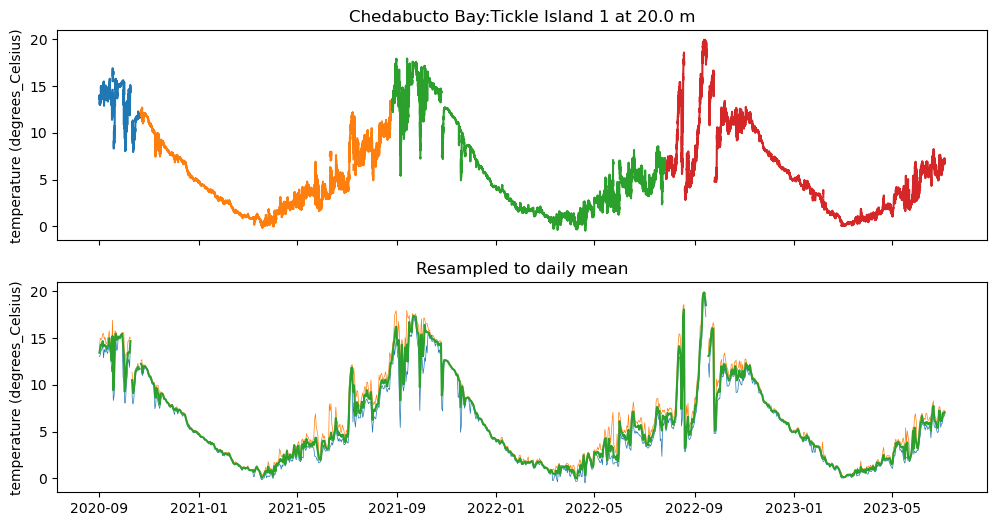

In [34]:
study_site = study_sites.iloc[37]

subset = df_metadata[ (df_metadata['waterbody'] == study_site['waterbody']) &  (df_metadata['station'] == study_site['station']) & (df_metadata['depth (m)'] == study_site['depth (m)'])]
display(subset)

fig, ax = plt.subplots(2,1, figsize=(12,6),sharex=True)

variable = 'temperature (degrees_Celsius)'
qc_flag = 'qc_flag_temperature'

series_segments = []
for index, row in subset.iterrows():

    csvfile = f"segments/{row['segment']}.csv"
       
    series = pd.read_csv(csvfile, index_col='time (UTC)', parse_dates=True)
    series.sort_index(inplace=True)

    # blank out observations that do not pass QC
    series[series[qc_flag] != 'Pass'] = np.nan
    series = series.drop(columns=[qc_flag])
    
    ax[0].plot(series.index, series[variable])
    
    ax[0].set_ylabel(variable)
    ax[0].set_title(f'{study_site.waterbody}:{study_site.station} at {study_site["depth (m)"]} m')

    if series.count()[variable] > 0:
        series_segments.append(series)

series_df = pd.concat(series_segments)
series_df.sort_index(inplace=True)

ax[1].set_title('Resampled to daily mean')
daily_series_df = series_df.resample('D').min()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='min', linewidth=0.5)
daily_series_df = series_df.resample('D').max()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='max', linewidth=0.5)
daily_series_df = series_df.resample('D').mean()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='mean')

ax[1].set_ylabel(variable)

plt.show()

At the time scale of four years, daily means are sufficient to see the cycle. The plot above shows the daily minimum and daily maximum.


## Combine segments into time series

We aggregate together these different segments from different deployments (and possibly different sensor) to create a complete daily time series at each station and depth in our study area:

In [36]:
start_date = "2020-09-01"
end_date = "2024-08-31"

daily_time_index = pd.date_range(start=start_date, end=end_date, freq='D')

all_timeseries = []

for study_site_id in tqdm(study_sites.index):

    study_site = study_sites.iloc[study_site_id]
    #print(f'[{study_site_id}] {study_site.waterbody}:{study_site.station} at {study_site['depth (m)']} m')
    study_site_name = f"{study_site.waterbody.replace(' ','')}_{study_site.station.replace(' ','')}_{study_site['depth (m)']:.0f}"
    
    subset = df_metadata[ (df_metadata['waterbody'] == study_site['waterbody']) &  (df_metadata['station'] == study_site['station']) & (df_metadata['depth (m)'] == study_site['depth (m)'])].copy()
    
    segments = []
    for segment_id, row in subset.iterrows():

        csvfile = f"segments/{row['segment']}.csv"
        segment = pd.read_csv(csvfile, index_col='time (UTC)', parse_dates=True)
        
        segment.sort_index(inplace=True)

        # blank out observations that do not pass QC
        segment[segment[qc_flag] != 'Pass'] = np.nan
        segment = segment.drop(columns=[qc_flag])

        if segment.count()[variable] > 0:
            segments.append(segment)

    if len(segments) > 0:
        
        timeseries = pd.concat(segments)
        timeseries.columns = [study_site_id]
        
        timeseries.sort_index(inplace=True)

        daily_timeseries = timeseries.resample('D').mean()

        all_timeseries.append(daily_timeseries)

dataset = pd.concat(all_timeseries, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:23<00:00,  8.74it/s]


This is our temperature dataset.  It also define the starting point for reproducing this analysis with a different data set.  We have measurements on same time resolution for many different measurements.  Each column in the dataset represents a different measurement.  We use `NaN` to represent daily measurements that are missing.

The goal of imputation is to make a good estimate of what values to replace those `NaN` that, while still an estimate, are justifiable.

In [39]:
dataset.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
time (UTC),,,,,,,,,,,,,,,,,,,,,
2023-07-24 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.999406,12.767354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-16 00:00:00+00:00,8.058333,7.670615,7.700000,NaN,NaN,NaN,7.479187,9.338380,7.987188,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-15 00:00:00+00:00,NaN,NaN,NaN,9.170833,15.488374,NaN,NaN,NaN,NaN,NaN,...,11.458750,11.166115,10.575771,10.677156,9.8000,10.595833,10.588125,10.568875,10.718844,10.258333
2021-07-08 00:00:00+00:00,NaN,12.495063,NaN,NaN,NaN,NaN,17.202146,17.569583,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.858417,7.882385,8.035979,8.073990,7.2625,8.055764,7.743472,7.724604,7.827937,7.447619
2020-09-09 00:00:00+00:00,14.945833,14.280479,NaN,NaN,NaN,NaN,NaN,NaN,15.698146,13.288885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-11 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.227781,3.206937,3.513281,3.545938,2.6875,3.567778,3.516667,3.477885,3.565979,3.191667
2023-10-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.183375,13.970708,13.624854,13.698240,12.8750,13.621250,13.288056,13.290250,13.403615,12.970833
2020-11-30 00:00:00+00:00,8.387500,8.624615,7.591667,NaN,NaN,NaN,5.928927,5.775972,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We save this dataset for subsequent analysis.  For this notebook series, any dataset in this form could be used for the subsequent steps in the analysis.

In [41]:
dataset.to_csv('dataset.csv')